# Parameter Recovery

This notebook will cover a simulated parameter recovery of drift rate and discount factor according to avgWTP_left, avgWTP_right, and fixation, as known, trial level data. Fixations are generated based on empirical distributions following Tavares' method.

In [2]:
bin_size = 0.001
seed = 42
model_conditions = {'drift_rate': 1.2, 'theta': 0.38, 'noise': 0.45}

In [ ]:
import simulation

path = '/Users/braydenchien/Desktop/Enkavilab/DDM/1ms_trial_data.csv'
empirical_distributions = simulation.get_empirical_distributions(path, bin_size)

Now we generate trials.

In [2]:
num_trials = 500
trials = simulation.create_trials(num_trials, empirical_distributions, seed=seed)

Create a model and simulate it using the generated trials.

In [ ]:
results_df = simulation.simulate(bin_size, model_conditions, trials, seed=seed, save_results=True)

Reformat fixations for model-free analysis.

In [4]:
import os
import organize_simulated_fixations

current_dir = '/Users/braydenchien/Desktop/Enkavilab/DDM'
organize_simulated_fixations.reformat_fixations(os.path.join(current_dir, 'simulated_data'), f'sim_trials_s{seed}_d{model_conditions['drift_rate']}_t{model_conditions['theta']}_n{model_conditions['noise']}.csv')

Generate plots from model-free analysis.

/Users/braydenchien/Desktop/Enkavilab/DDM/mfa.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = first_fix_df.groupby('diff_bin')['toward_larger'].agg(['mean', sem]).reset_index()
/Users/braydenchien/Desktop/Enkavilab/DDM/mfa.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = middle_fix_df.groupby('diff_bin')['fix_dur'].agg(['mean', sem]).reset_index()
/Users/braydenchien/.pyenv/versions/DDM/lib/python3.12/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size re

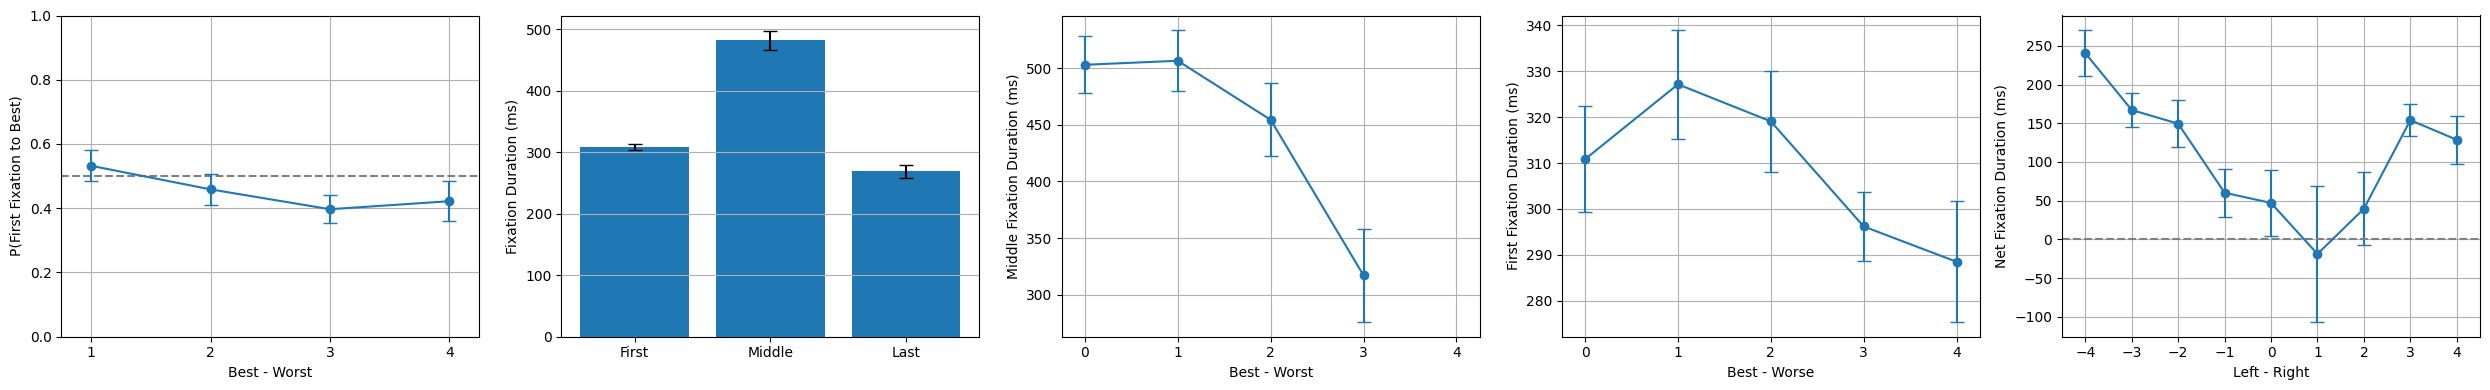

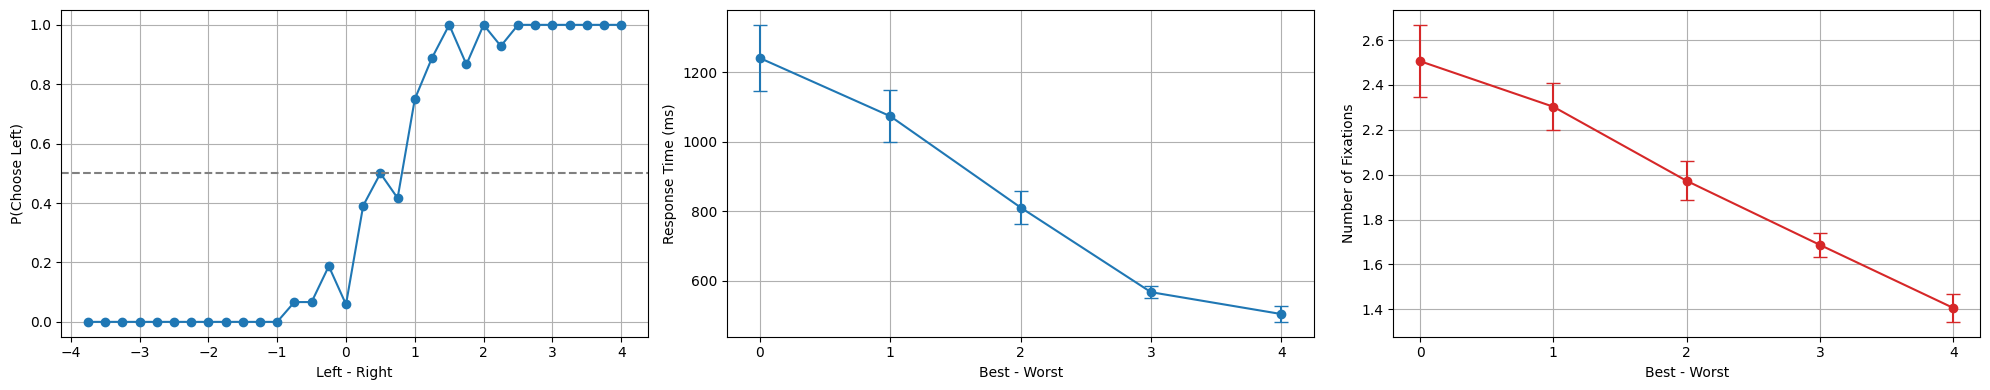

In [3]:
import mfa

formatted_parent_dir = '/Users/braydenchien/Desktop/Enkavilab/DDM/formatted_data'
formatted_data_path = f'sim_trials_s{seed}_d{model_conditions['drift_rate']}_t{model_conditions['theta']}_n{model_conditions['noise']}.csv'
mfa.save_fixation_properties(formatted_parent_dir, formatted_data_path)
mfa.save_basic_psychometrics(formatted_parent_dir, formatted_data_path)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trajectory(trial, model_conditions):
    """
    Plots the trajectory of the decision variable over time,
    shading periods of fixation left/right.

    Parameters:
    - trial: dict with keys:
        - 'trajectory': list or np.array of decision variable
        - 'fixation': list or np.array of fixation states (1=left, 2=right)
        - etc.
    """
    model = simulation.create_model(model_conditions['drift_rate'], model_conditions['theta'], model_conditions['noise'])

    trajectory = np.array(trial['trajectory'])
    fixation = np.array(trial['fixation'])
    timesteps = np.arange(len(trajectory)) * model.dt

    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot trajectory line
    ax.plot(timesteps, trajectory, color="black", label="Trajectory")

    # Identify contiguous fixation segments
    current_state = fixation[0]
    start_idx = 0
    for i in range(1, len(fixation)):
        if fixation[i] != current_state or i == len(fixation) - 1:
            end_idx = i if fixation[i] != current_state else i + 1
            if current_state == 1:
                ax.axvspan(timesteps[start_idx], timesteps[end_idx - 1], color="blue", alpha=0.2, label="Fixation Left" if start_idx == 0 else "")
            elif current_state == 2:
                ax.axvspan(timesteps[start_idx], timesteps[end_idx - 1], color="red", alpha=0.2, label="Fixation Right" if start_idx == 0 else "")
            start_idx = i
            current_state = fixation[i]

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Decision Variable")
    ax.set_title("aDDM Accumulation Trajectory with Fixation Shading")
    ax.grid(True)

    # Avoid duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

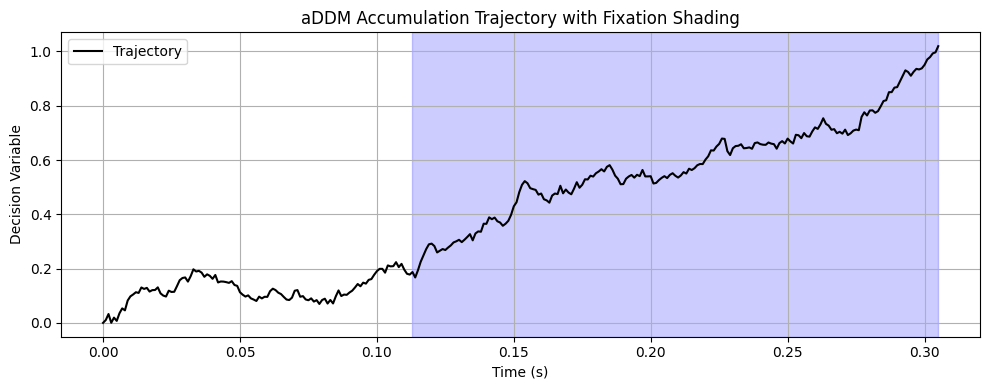

In [9]:
plot_trajectory(results_df.loc[4], model_conditions)

In [ ]:
import seaborn as sns

def grid_simulation(drift_rates, noise_levels):
    theta = 0.38

    # Preallocate a grid for trial counts
    trial_grid = np.full((len(noise_levels), len(drift_rates)), np.nan)

    for i, noise in enumerate(noise_levels):
        for j, drift in enumerate(drift_rates):
            model = create_model(drift, theta, noise)
            try:
                results = simulate(bin_size, model, trials, seed, save_results=False)
                good_trials = valid_trials(results)
                trial_grid[i, j] = good_trials

                if good_trials > len(trials) * 0.95:
                    print(f'Successful parameter combination drift rate: {drift}, noise: {noise}')

                    # Plot heatmap before returning
                    plt.figure(figsize=(8, 6))
                    sns.heatmap(trial_grid, annot=True, fmt=".0f",
                                xticklabels=np.round(drift_rates, 2),
                                yticklabels=np.round(noise_levels, 2),
                                cmap="YlGnBu")
                    plt.xlabel('Drift Rate')
                    plt.ylabel('Noise Level')
                    plt.title('Valid Trials per Parameter Combination')
                    plt.show()

                    return results

            except ValueError:
                print(f'Parameter combination drift rate: {drift}, noise: {noise} results in timeout')
                trial_grid[i, j] = np.nan  # Could also set to 0 if preferred

    # Plot heatmap even if no early return
    plt.figure(figsize=(8, 6))
    sns.heatmap(trial_grid, annot=True, fmt=".0f",
                xticklabels=np.round(drift_rates, 2),
                yticklabels=np.round(noise_levels, 2),
                cmap="YlGnBu")
    plt.xlabel('Drift Rate')
    plt.ylabel('Noise Level')
    plt.title('Valid Trials per Parameter Combination')
    plt.show()

    return None  # If no good result found

Parameter combination drift rate: 0.5, noise: 0.3 results in timeout
Parameter combination drift rate: 1.0, noise: 0.3 results in timeout
Parameter combination drift rate: 1.5, noise: 0.3 results in timeout
Parameter combination drift rate: 0.5, noise: 0.39999999999999997 results in timeout
Parameter combination drift rate: 0.5, noise: 0.5 results in timeout


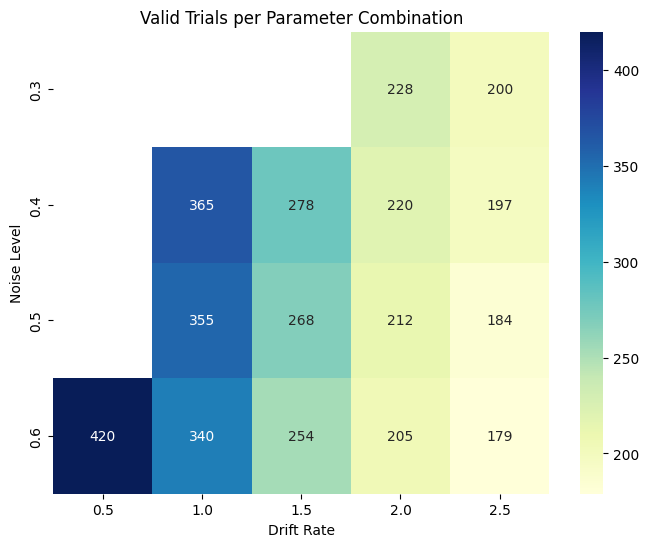

In [ ]:
good_result_df = grid_simulation(np.linspace(0.5, 2.5, 5), np.linspace(0.3, 0.6, 4))